# Define Reward position on .avi files
#### Choose a path that contains one or mutliple .avi files. A window will open and tqqhe first frame of each video will be diplayed. Click on the frame where the reward position was. A red cross will appear at the location. Click again to change the location of the reward. Press "q" to go to the next video. If you clicked on the frame, the X Y positions will be saved as a text file in the folder conainting the video. If you pressed "q" and did not click on the frame, nothing will be saved.

In [ ]:
# Path to the root folder containing video files
video_folder = '//10.69.168.1/crnldata/forgetting/Aurelie/CheeseboardExperiment/DAQ_data/AB/Test/'

In [ ]:
file="//10.69.168.1/crnldata/forgetting/Aurelie/CheeseboardExperiment/DAQ_data/AB/Test/Lou/Cheeseboard/2024_12_06/11_07_47/My_First_WebCam/0_compressed.avi"

if '/Cheeseboard/' in file and 'DLC' not in file:
    print('ok')

In [ ]:
import cv2
import os

# Global variable to store the click position
click_position = None
frame_copy = None

# Callback function to handle mouse click events
def on_click(event, x, y, flags, param):
    global click_position, frame_copy
    if event == cv2.EVENT_LBUTTONDOWN:  # Left mouse button click
        click_position = (x, y)
        print(f"Clicked at: ({x}, {y})")
        
        # Draw a red cross at the clicked position
        # Create a copy of the frame to draw the cross
        frame_copy = frame.copy()
        cv2.line(frame_copy, (x-20, y), (x+20, y), (0, 0, 255), 2)  # Horizontal line
        cv2.line(frame_copy, (x, y-20), (x, y+20), (0, 0, 255), 2)  # Vertical line

# Function to save the last click position to a text file
def save_click_position(video_path, position):
    if position:
        # Create the text file path by changing extension to .txt
        txt_file_path = os.path.splitext(video_path)[0] + "_reward_position.txt"
        with open(txt_file_path, 'w') as f:
            f.write(f"Reward Position: x={position[0]}, y={position[1]}")
        print(f"Saved reward position to {txt_file_path}")


# Walk through the directory recursively
for root, dirs, files in os.walk(video_folder):
    # Filter for video files (avi, mp4, mov)
    video_files = [f for f in files if f.endswith(('.avi', '.mp4', '.mov'))]
    
    # Process only videos where path contains "MyFirstWebcam"
    for video_file in video_files:
        video_path = os.path.join(root, video_file)
        # Normalize the path to avoid mixed slashes
        video_path = os.path.normpath(video_path)
        #print(video_path)
        
        if "My_First_WebCam" in video_path and "Cheeseboard" in video_path and 'DLC' not in video_file:
            
            # Load the video file
            cap = cv2.VideoCapture(video_path)

            # Check if the video file is opened
            if not cap.isOpened():
                print(f"Error: Could not open video {video_file}")
                continue

            # Read the first frame
            ret, frame = cap.read()
            if not ret:
                print(f"Error: Could not read the first frame of {video_file}")
                cap.release()
                continue

            # Create a copy of the frame to update it after click
            frame_copy = frame.copy()

            # Display the first frame using OpenCV
            cv2.imshow(video_path, frame_copy)

            # Set up the callback for mouse clicks
            cv2.setMouseCallback(video_path, on_click)
            click_position = None

            # Wait for a key press (user can click on the frame)
            while True:
                # Display the updated frame (with red cross if clicked)
                cv2.imshow(video_path, frame_copy)
                
                # Wait for a key press
                key = cv2.waitKey(1) & 0xFF
                if key == ord('q'):  # Press 'q' to quit
                    break

            # Save the click position to a text file before quitting
            if click_position:
                save_click_position(video_path, click_position)

            # Release the video and close the window
            cap.release()
            cv2.destroyAllWindows()

print("Processing completed for all relevant videos.")

Note: the cheeseboard table diameter is equal to 270 pix (= 120cm) so 
1 cm = 2.25 pix or
20 cm = 45 pix

In [280]:
filename = "//10.69.168.1/crnldata/forgetting/Aurelie/CheeseboardExperiment/DAQ_data/AB/Training/Green/Cheeseboard/2024_12_03/18_02_07/My_First_WebCam/0_compressedDLC_resnet50_CheeseboardMiniscopeFeb21shuffle1_59000.h5"

Total trial duration: 34 sec
Latency to reward: 9.0 sec
Time spent in reward zone: 25.5 sec (74 %)
Number of entrances in the reward zone: 1
Total distance run: 197 cm
Distance run to reward: 157 cm
Crossings per meter: 0.64


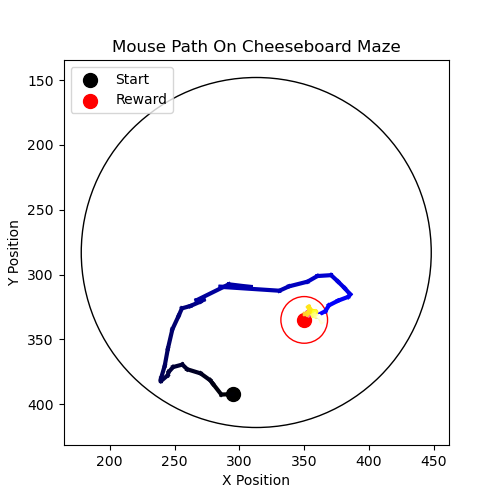

In [284]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math

%matplotlib widget

# Define parameters
pixel_to_cm = 2.25  
reward_x, reward_y = 350, 335  # Update if different reward location
reward_zone = 8 * pixel_to_cm if "Training" in filename else 20 * pixel_to_cm  # 8 cm for training, 20 cm for test
table_center_x, table_center_y = 313, 283  # Center of the cheeseboard table on the video
table_radius = 270 / 2
frame_rate = 4  # FPS
min_stay_at_reward = 5 * frame_rate  # 5 seconds

# Function to calculate the Euclidean distance
def calculate_distance(x1, y1, x2, y2):
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

def calculate_total_distance(x_coords, y_coords):
    distances = np.sqrt(np.diff(x_coords) ** 2 + np.diff(y_coords) ** 2)
    total_distance_cm = np.sum(distances) / pixel_to_cm  # Convert to cm
    return total_distance_cm

# Load HDF5 file
df = pd.read_hdf(filename)
df.to_csv(filename.replace(".h5", ".csv"))

# Remove uncertain location predictions (likelihood < 0.9)
df.iloc[:, 0] = df.apply(lambda row: row.iloc[0] if row.iloc[-1] > 0.9 else np.nan, axis=1)
df.iloc[:, 1] = df.apply(lambda row: row.iloc[1] if row.iloc[-1] > 0.9 else np.nan, axis=1)

X = df.iloc[:, 0]
Y = df.iloc[:, 1]

# Separate the individual's positions into x and y coordinates
individual_x = np.array(X.values)
individual_y = np.array(Y.values)

# Define when the mouse is on the cheeseboard (start)
for i, x in enumerate(individual_x):
    y = individual_y[i]
    if calculate_distance(x, y, table_center_x, table_center_y) >= table_radius:
        individual_x[i] = np.nan
        individual_y[i] = np.nan

x_start = individual_x[~np.isnan(individual_x)][0] if np.any(~np.isnan(individual_x)) else None
y_start = individual_y[~np.isnan(individual_y)][0] if np.any(~np.isnan(individual_y)) else None
start_time = np.where(individual_x == x_start)[0]
duration_trial = (len(individual_x) - start_time) / frame_rate
print(f'Total trial duration: {round(duration_trial.item())} sec')

# Define when the mouse eats the reward (end)
found_reward = np.nan
consecutive_count = 0
for i, (x, y) in enumerate(zip(individual_x, individual_y)):
    if calculate_distance(x, y, reward_x, reward_y) <= reward_zone:
        consecutive_count += 1
    else:
        consecutive_count = 0  
    if consecutive_count > min_stay_at_reward:
        found_reward = (i - min_stay_at_reward)
        break

latency = (found_reward - start_time) / frame_rate
print(f'Latency to reward: {latency.item()} sec')

# Define the time spent inside the reward zone
time_spent_in_zone = 0

for i, (x, y) in enumerate(zip(individual_x, individual_y)):
    if calculate_distance(x, y, reward_x, reward_y) <= reward_zone:
        time_spent_in_zone += 1

time_spent_in_zone = time_spent_in_zone / frame_rate
print(f'Time spent in reward zone: {time_spent_in_zone} sec ({round(time_spent_in_zone / duration_trial.item() * 100)} %)')

# Define the number of times the mouse enters the reward zone
enter_reward_zone = 0
consecutive_count = 0

for i, (x, y) in enumerate(zip(individual_x, individual_y)):
    if calculate_distance(x, y, reward_x, reward_y) <= reward_zone:
        if consecutive_count == 0:
            enter_reward_zone += 1
            consecutive_count = 1
    else:
        consecutive_count = 0   

print(f'Number of entrances in the reward zone: {enter_reward_zone}')

# Create the plot
fig, ax = plt.subplots(figsize=(5, 5)) 

# Remove NaN values to get a cleaner plot
individual_x = individual_x[~np.isnan(individual_x)]        
individual_y = individual_y[~np.isnan(individual_y)]

total_distance = calculate_total_distance(individual_x, individual_y)
print(f"Total distance run: {round(total_distance)} cm")

distance_to_reward = calculate_total_distance(individual_x[:found_reward-start_time.item()], individual_y[:found_reward-start_time.item()])
print(f'Distance run to reward: {round(distance_to_reward)} cm')

print(f"Crossings per meter: {round(enter_reward_zone / (round(distance_to_reward) / 100), 2)}")

# Plot individual positions over time
cmap = plt.get_cmap('gnuplot2')
norm = plt.Normalize(vmin=0, vmax=len(individual_x))

for i in range(1, len(individual_x)):
    ax.plot(individual_x[i-1:i+1], individual_y[i-1:i+1], color=cmap(norm(i)), linewidth=3)
#plt.plot(individual_x, individual_y, label="Individual's Path", color='b')

plt.scatter(x_start, y_start, color='black', s=100, label='Start')
plt.scatter(reward_x, reward_y, color='red', s=100, label='Reward')

# Draw reward zone circle
reward_circle = plt.Circle((reward_x, reward_y), reward_zone, color='r', fill=False)
plt.gca().add_patch(reward_circle)  

# Draw cheeseboard circle
table_circle = plt.Circle((table_center_x, table_center_y), table_radius, color='k', fill=False)
plt.gca().add_patch(table_circle) 

# Add labels and title
ax.set_aspect('equal')
ax.invert_yaxis()
plt.title(f'Mouse Path On Cheeseboard Maze')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend(loc='upper left')
plt.show()
